In [1]:
import os
os.chdir('../..')
!ls

product_impacts


python(9629) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [2]:
import os.path
import pandas as pd
from skimpy import skim
import requests
from bs4 import BeautifulSoup
import statistics
from sentence_transformers import SentenceTransformer, util
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, matthews_corrcoef, f1_score, mean_squared_error, r2_score, roc_auc_score, balanced_accuracy_score, precision_score, recall_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import preprocessing
from sklearn.feature_selection import mutual_info_classif
from hiclass import LocalClassifierPerParentNode, LocalClassifierPerLevel

from product_impacts.product_cat.run_model import get_store, get_ndns_cats, get_products, get_ndns_matches, get_tsne

import numpy as np
import pickle
import json

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc

sns.set()

python(9870) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
os.environ["RAY_ENABLE_MAC_LARGE_OBJECT_STORE"] = "1"

In [5]:
ndns = get_ndns_cats('../../SFS/NDNS UK/ndns_edited.csv')
products = get_products()
labelled_data, non_food_products = get_ndns_matches(
    ndns, products)

/Users/shruti/anaconda3/envs/ct_map/lib/python3.7/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Data Validation extension is not supported and will be removed
  for idx, row in parser.parse():


In [6]:
# removing duplicated product names + ingredients (basically products with same exact feature vectors)
labelled_data['product_list_name_lower'] = labelled_data['product_list_name'].str.lower()
labelled_data['ingredients_text_lower'] = labelled_data['ingredients_text'].str.lower()
labelled_data = labelled_data.drop_duplicates(
    subset=['product_list_name_lower', 'ingredients_text_lower']).reset_index(drop=True)

In [7]:
# lev 0 predictions
predicted_data = pd.read_csv('../../SFS/NDNS UK/predictions/predictions_lev0_manuallabels_nonHI_RF_withcorrections_14Oct2024.csv')

In [8]:
predicted_data.shape

(262711, 11)

In [9]:
predicted_data['parentcategory_pred'].value_counts()

Cereals and Cereal Products             52426
Miscellaneous                           27598
Meat and Meat Products                  26837
Non-Alcoholic Beverages                 25994
Sugar, Preserves and Confectionery      25822
Vegetables, Potatoes                    23757
Milk and Milk Products                  23239
Alcoholic Beverages                     15150
Fish and Fish Dishes                     9302
Fruit                                    7343
Savoury Snacks                           6460
Not Food                                 5086
Nuts and Seeds                           5057
Fat Spreads                              3811
Commercial Toddlers Foods and Drinks     2488
Eggs and Egg Dishes                      1315
Dietary Supplements                       622
Artificial Sweeteners                     404
Name: parentcategory_pred, dtype: int64

In [10]:
pred = predicted_data[predicted_data['parentcategory_pred']=='Milk and Milk Products'].reset_index(drop=True)
lab = labelled_data[(labelled_data['parentcategory']=='Milk and Milk Products')
                           & (labelled_data['subfoodgroupdesc'].notnull())].reset_index(drop=True)
lab = lab.merge(pred[['product_id']])

In [11]:
pred.shape

(23239, 11)

In [12]:
lab.shape

(5844, 12)

In [13]:
lab['subfoodgroupdesc'].value_counts()

Yogurt                                    1555
Ice cream                                 1190
Other cheese                              1014
Cheddar cheese                             755
Other milk                                 586
Fromage frais and other dairy desserts     211
Cream (including imitation cream)          177
Whole milk                                  97
Semi-skimmed milk                           97
Cottage cheese                              71
Skimmed milk                                69
1% Milk                                     11
Infant formula                              11
Name: subfoodgroupdesc, dtype: int64

In [14]:
lab['mainfoodgroupdesc'].value_counts()

Cheese                                            1840
Yogurt, fromage frais and other dairy desserts    1766
Ice cream                                         1190
Other milk and cream                               774
Whole milk                                          97
Semi-skimmed milk                                   97
Skimmed milk                                        69
1% Milk                                             11
Name: mainfoodgroupdesc, dtype: int64

In [15]:
pred['subfoodgroup_lab'].value_counts()

Yogurt                                                           1553
Ice cream                                                        1189
Other cheese                                                     1014
Cheddar cheese                                                    755
Other milk                                                        568
Fromage frais and other dairy desserts                            214
Cream (including imitation cream)                                 177
Whole milk                                                         97
Semi-skimmed milk                                                  97
Cereal based milk puddings                                         76
Cottage cheese                                                     71
Skimmed milk                                                       69
Nuts and seeds                                                     35
Nutrition powders and drinks                                       31
Infant formula      

In [16]:
lev2_labels_add = pred[[
    'product_id', 'product_list_name', 'product_name', 'ingredients_text', 'store']]
lev2_labels_add['parentcategory'] = 'Milk and Milk Products'
lev2_labels_add['subfoodgroupdesc'] = np.NaN

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('devon custard')), 
                   'subfoodgroupdesc'] = 'Fromage frais and other dairy desserts'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('ready to serve custard')), 
                   'subfoodgroupdesc'] = 'Fromage frais and other dairy desserts'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('vanilla custard')), 
                   'subfoodgroupdesc'] = 'Fromage frais and other dairy desserts'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("custard"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("ambrosia")), 
                   'subfoodgroupdesc'] = 'Fromage frais and other dairy desserts'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("custard"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("alpro")), 
                   'subfoodgroupdesc'] = 'Fromage frais and other dairy desserts'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('panna cotta')), 
                   'subfoodgroupdesc'] = 'Fromage frais and other dairy desserts'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('strawberry fromage frais')), 
                   'subfoodgroupdesc'] = 'Fromage frais and other dairy desserts'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('strawberry mousse')), 
                   'subfoodgroupdesc'] = 'Fromage frais and other dairy desserts'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('essential waitrose custard')), 
                   'subfoodgroupdesc'] = 'Fromage frais and other dairy desserts'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('fresh custard')), 
                   'subfoodgroupdesc'] = 'Fromage frais and other dairy desserts'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('roulade')), 
                   'subfoodgroupdesc'] = 'Fromage frais and other dairy desserts'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('coffee & caramel dessert')), 
                   'subfoodgroupdesc'] = 'Fromage frais and other dairy desserts'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('strawberry dessert')), 
                   'subfoodgroupdesc'] = 'Fromage frais and other dairy desserts'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains('lime posset')), 
                   'subfoodgroupdesc'] = 'Fromage frais and other dairy desserts'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("alpro smooth chocolate")), 
                   'subfoodgroupdesc'] = 'Fromage frais and other dairy desserts'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("fromage frais 12pack")), 
                   'subfoodgroupdesc'] = 'Fromage frais and other dairy desserts'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("cathedral city"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("snackbar")), 
                   'subfoodgroupdesc'] = 'Cheddar cheese'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("marmite cheddar")), 
                   'subfoodgroupdesc'] = 'Cheddar cheese'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("gloucester")), 
                   'subfoodgroupdesc'] = 'Other cheese'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("jarlsberg")), 
                   'subfoodgroupdesc'] = 'Other cheese'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("british blue")), 
                   'subfoodgroupdesc'] = 'Other cheese'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("savers soft cheese")), 
                   'subfoodgroupdesc'] = 'Other cheese'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("bishop blue stilton")), 
                   'subfoodgroupdesc'] = 'Other cheese'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("cheshire cheese")), 
                   'subfoodgroupdesc'] = 'Other cheese'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("chevington sliced")), 
                   'subfoodgroupdesc'] = 'Other cheese'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("kirkham's lancashire")), 
                   'subfoodgroupdesc'] = 'Other cheese'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("twarog")), 
                   'subfoodgroupdesc'] = 'Other cheese'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("lancashire"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("yogurt")), 
                   'subfoodgroupdesc'] = 'Yogurt'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("wildlife"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("yogurt")), 
                   'subfoodgroupdesc'] = 'Yogurt'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("frubes"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("yogurt")), 
                   'subfoodgroupdesc'] = 'Yogurt'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("tesco greek style natural")), 
                   'subfoodgroupdesc'] = 'Yogurt'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("gold top")), 
                   'subfoodgroupdesc'] = 'Whole milk'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("british whole milk")), 
                   'subfoodgroupdesc'] = 'Whole milk'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("2% milk")), 
                   'subfoodgroupdesc'] = 'Semi-skimmed milk'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("british semi skimmed milk")), 
                   'subfoodgroupdesc'] = 'Semi-skimmed milk'


lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("avonmore chrsl reducing milk")), 
                   'subfoodgroupdesc'] = '1% Milk'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("avonmore"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("1%")), 
                   'subfoodgroupdesc'] = '1% Milk'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("milk"))
                    & (lev2_labels_add['product_list_name'].str.lower().str.contains("1%")), 
                   'subfoodgroupdesc'] = '1% Milk'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("avonmore fresh light milk")), 
                   'subfoodgroupdesc'] = '1% Milk'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("fat-free milk")), 
                   'subfoodgroupdesc'] = 'Skimmed milk'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("british skimmed milk")), 
                   'subfoodgroupdesc'] = 'Skimmed milk'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("reduced fat coconut milk")), 
                   'subfoodgroupdesc'] = 'Other milk'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("skimmed goats milk")), 
                   'subfoodgroupdesc'] = 'Other milk'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("whole goats milk")), 
                   'subfoodgroupdesc'] = 'Other milk'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("uht goats milk")), 
                   'subfoodgroupdesc'] = 'Other milk'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("blue dragon coconut milk")), 
                   'subfoodgroupdesc'] = 'Other milk'

lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("haagen - dazs")), 
                   'subfoodgroupdesc'] = 'Ice cream'

/Users/shruti/anaconda3/envs/ct_map/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/shruti/anaconda3/envs/ct_map/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/shruti/anaconda3/envs/ct_map/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A val

In [17]:
# lev2_labels_add.loc[(lev2_labels_add['product_list_name'].str.lower().str.contains("fromage frais 12pack"))
#                    ]

In [18]:
lev2_labels_add = lev2_labels_add.merge(
    ndns.drop('detaileddesc', axis=1)).drop_duplicates(subset=['product_id', 'subfoodgroupdesc'])
lev2_labels_add['product_list_name_lower'] = lev2_labels_add['product_list_name'].str.lower()
lev2_labels_add['ingredients_text_lower'] = lev2_labels_add['ingredients_text'].str.lower()
lev2_labels_add = lev2_labels_add.drop_duplicates(
    subset=['product_list_name_lower', 'ingredients_text_lower']).reset_index(drop=True)

dups = lab[['product_id', 'product_list_name_lower', 'ingredients_text_lower', 'subfoodgroupdesc']].merge(
    lev2_labels_add[['product_list_name_lower', 'ingredients_text_lower', 'subfoodgroupdesc']])['product_id'].values
lev2_labels_add = lev2_labels_add[(~lev2_labels_add['product_id'].isin(dups))]
lab = lab[(~lab['product_id'].isin(lev2_labels_add['product_id'].values))]
lab = pd.concat([lab, lev2_labels_add], ignore_index=True, axis=0).drop_duplicates(
    subset=['product_list_name_lower', 'ingredients_text_lower']).reset_index(drop=True)

In [19]:
lab.shape

(6348, 12)

In [20]:
lab['subfoodgroupdesc'].value_counts()

Yogurt                                    1600
Ice cream                                 1187
Other cheese                              1121
Cheddar cheese                             734
Other milk                                 597
Fromage frais and other dairy desserts     535
Cream (including imitation cream)          177
Whole milk                                 107
Semi-skimmed milk                          107
Skimmed milk                                72
Cottage cheese                              71
1% Milk                                     29
Infant formula                              11
Name: subfoodgroupdesc, dtype: int64

In [21]:
pred = pred.drop('mainfoodgroup_lab', axis=1).merge(
    lab[['product_id', 'mainfoodgroupdesc']], how='left').rename(columns={'mainfoodgroupdesc': 'mainfoodgroup_lab'})

pred = pred.drop('subfoodgroup_lab', axis=1).merge(
    lab[['product_id', 'subfoodgroupdesc']], how='left').rename(columns={'subfoodgroupdesc': 'subfoodgroup_lab'})

In [22]:
query_embeddings = np.load('../../SFS/bert/all_embeddings_all3.npy')
tsne_results = get_tsne(query_embeddings, '../../SFS/bert/tsne_results_all3.npy')
product_ids = np.load('../../SFS/bert/all_ids_all3.npy')

features = pd.DataFrame(data=query_embeddings)
id_col = 'product_id'
X_cols = features.columns.tolist()
y_cols = ['parentcategory', 'mainfoodgroupdesc', 'subfoodgroupdesc']

features['product_id'] = pd.Series(product_ids, index=features.index)
features[['tsne_0', 'tsne_1']] = tsne_results
lab = lab.merge(features)

In [23]:
acc_list_train = []
bal_acc_list_train = []
precision_list_train = []
recall_list_train = []
f1_list_train = []
mcc_list_train = []

acc_list_test = []
bal_acc_list_test = []
precision_list_test = []
recall_list_test = []
f1_list_test = []
mcc_list_test = []

for i in range(1):
    train, test = train_test_split(lab, test_size=0.2, random_state=i)
    print(f'Number of unique level 1 categories in train: {train[y_cols[1]].nunique()}')
    print(f'Number of unique level 1 categories in test: {test[y_cols[1]].nunique()}')
    print(f'Number of unique level 2 categories in train: {train[y_cols[2]].nunique()}')
    print(f'Number of unique level 2 categories in test: {test[y_cols[2]].nunique()}\n')

    X_train = train[X_cols]
    y_train = train[[y_cols[1], y_cols[2]]]
    y_train1 = train[y_cols[1]]
    y_train2 = train[y_cols[2]]

    X_test = test[X_cols]
    y_test = test[[y_cols[1], y_cols[2]]]
    y_test1 = test[y_cols[1]]
    y_test2 = test[y_cols[2]]

    mod = RandomForestClassifier(n_estimators=400, 
                                 min_samples_leaf=10, 
                                 max_depth=25,
                                 class_weight='balanced'
                                )

    clf2 = mod
    clf2.fit(X_train, y_train2)
    y_train_pred2 = clf2.predict(X_train)
    y_test_pred2 = clf2.predict(X_test)

    y_train_pred1 = pd.DataFrame(y_train_pred2, columns=[y_cols[2]]).merge(
        lab[[y_cols[1], y_cols[2]]].drop_duplicates(), how='left')[y_cols[1]].values
    y_test_pred1 = pd.DataFrame(y_test_pred2, columns=[y_cols[2]]).merge(
        lab[[y_cols[1], y_cols[2]]].drop_duplicates(), how='left')[y_cols[1]].values

    print(f'Lev 1 train accuracy: {accuracy_score(y_train1, y_train_pred1)}')
    print(f'Lev 1 train balanced accuracy: {balanced_accuracy_score(y_train1, y_train_pred1)}')
    print(f'Lev 1 test accuracy: {accuracy_score(y_test1, y_test_pred1)}')
    print(f'Lev 1 test balanced accuracy: {balanced_accuracy_score(y_test1, y_test_pred1)}\n')

    print(f'Lev 2 train accuracy: {accuracy_score(y_train2, y_train_pred2)}')
    print(f'Lev 2 train balanced accuracy: {balanced_accuracy_score(y_train2, y_train_pred2)}')
    print(f'Lev 2 test accuracy: {accuracy_score(y_test2, y_test_pred2)}')
    print(f'Lev 2 test balanced accuracy: {balanced_accuracy_score(y_test2, y_test_pred2)}\n')

    print(f'Number of unique level 1 categories predicted in train: {len(np.unique(y_train_pred1))}')
    print(f'Number of unique level 1 categories predicted in test: {len(np.unique(y_test_pred1))}')    
    print(f'Number of unique level 2 categories predicted in train: {len(np.unique(y_train_pred2))}')
    print(f'Number of unique level 2 categories predicted in test: {len(np.unique(y_test_pred2))}\n')    
    
    acc_list_train.append(accuracy_score(y_train2, y_train_pred2))
    bal_acc_list_train.append(balanced_accuracy_score(y_train2, y_train_pred2))
    precision_list_train.append(precision_score(y_train2, y_train_pred2, average='weighted'))
    recall_list_train.append(recall_score(y_train2, y_train_pred2, average='weighted'))
    f1_list_train.append(f1_score(y_train2, y_train_pred2, average='weighted'))
    mcc_list_train.append(matthews_corrcoef(y_train2, y_train_pred2))
    
    acc_list_test.append(accuracy_score(y_test2, y_test_pred2))
    bal_acc_list_test.append(balanced_accuracy_score(y_test2, y_test_pred2))
    precision_list_test.append(precision_score(y_test2, y_test_pred2, average='weighted'))
    recall_list_test.append(recall_score(y_test2, y_test_pred2, average='weighted'))
    f1_list_test.append(f1_score(y_test2, y_test_pred2, average='weighted'))
    mcc_list_test.append(matthews_corrcoef(y_test2, y_test_pred2))

Number of unique level 1 categories in train: 8
Number of unique level 1 categories in test: 8
Number of unique level 2 categories in train: 13
Number of unique level 2 categories in test: 13

Lev 1 train accuracy: 0.9907443875541552
Lev 1 train balanced accuracy: 0.9927867383904986
Lev 1 test accuracy: 0.9637795275590552
Lev 1 test balanced accuracy: 0.9043604717595013

Lev 2 train accuracy: 0.9844426939740055
Lev 2 train balanced accuracy: 0.9910803236948761
Lev 2 test accuracy: 0.9425196850393701
Lev 2 test balanced accuracy: 0.9142995819584276

Number of unique level 1 categories predicted in train: 8
Number of unique level 1 categories predicted in test: 8
Number of unique level 2 categories predicted in train: 13
Number of unique level 2 categories predicted in test: 13



In [24]:
print('train')
print(f'accuracy: {statistics.mean(acc_list_train)}')
print(f'balanced accuracy: {statistics.mean(bal_acc_list_train)}')
print(f'precision: {statistics.mean(precision_list_train)}')
print(f'recall: {statistics.mean(recall_list_train)}')
print(f'f1: {statistics.mean(f1_list_train)}')
print(f'mcc: {statistics.mean(mcc_list_train)}')

print('test')
print(f'accuracy: {statistics.mean(acc_list_test)}')
print(f'balanced accuracy: {statistics.mean(bal_acc_list_test)}')
print(f'precision: {statistics.mean(precision_list_test)}')
print(f'recall: {statistics.mean(recall_list_test)}')
print(f'f1: {statistics.mean(f1_list_test)}')
print(f'mcc: {statistics.mean(mcc_list_test)}')

train
accuracy: 0.9844426939740055
balanced accuracy: 0.9910803236948761
precision: 0.9849928936372738
recall: 0.9844426939740055
f1: 0.9845389989492974
mcc: 0.9815002510272788
test
accuracy: 0.9425196850393701
balanced accuracy: 0.9142995819584276
precision: 0.9448197366984838
recall: 0.9425196850393701
f1: 0.942993200376734
mcc: 0.9315326415177422


In [24]:
X_train = lab[X_cols]
y_train = lab[[y_cols[1], y_cols[2]]]
y_train1 = lab[y_cols[1]]
y_train2 = lab[y_cols[2]]

pred = pred.drop(['tsne_0', 'tsne_1'], axis=1).merge(features)
X_pred = pred[X_cols]

mod = RandomForestClassifier(n_estimators=400, 
                             min_samples_leaf=10, 
                             max_depth=10,
                             class_weight='balanced')

clf2 = mod
clf2.fit(X_train, y_train2)
y_train_pred2 = clf2.predict(X_train)
y_pred2 = clf2.predict(X_pred)

y_train_pred1 = pd.DataFrame(y_train_pred2, columns=[y_cols[2]]).merge(
    lab[[y_cols[1], y_cols[2]]].drop_duplicates(), how='left')[y_cols[1]].values
y_pred1 = pd.DataFrame(y_pred2, columns=[y_cols[2]]).merge(
    lab[[y_cols[1], y_cols[2]]].drop_duplicates(), how='left')[y_cols[1]].values


print(f'Lev 2 train accuracy: {accuracy_score(y_train2, y_train_pred2)}')
print(f'Lev 2 train balanced accuracy: {balanced_accuracy_score(y_train2, y_train_pred2)}')

print(f'Number of unique level 2 categories in train: {len(np.unique(y_train_pred2))}')
print(f'Number of unique level 2 categories in pred: {len(np.unique(y_pred2))}')    

pred['mainfoodgroup_pred'] = pd.Series(y_pred1, index = pred.index)
pred['subfoodgroup_pred'] = pd.Series(y_pred2, index = pred.index)

cols = ['product_id', 'product_name', 'product_list_name', 'store', 'ingredients_text',
        'parentcategory_lab', 'mainfoodgroup_lab', 'subfoodgroup_lab',
        'parentcategory_pred', 'mainfoodgroup_pred', 'subfoodgroup_pred', 'tsne_0', 'tsne_1']

pred = pred[cols]

print(pred[(pred['subfoodgroup_lab'].notnull()) & (pred['parentcategory_lab']==pred['parentcategory_pred'])
           & (pred['subfoodgroup_lab']!=pred['subfoodgroup_pred'])].shape)

Lev 2 train accuracy: 0.9766855702583491
Lev 2 train balanced accuracy: 0.9862434747695246
Number of unique level 2 categories in train: 13
Number of unique level 2 categories in pred: 13
(140, 13)


In [25]:
pred['subfoodgroup_pred'].value_counts()

Yogurt                                    6166
Other cheese                              4544
Ice cream                                 3936
Other milk                                3368
Cheddar cheese                            1845
Fromage frais and other dairy desserts    1381
Cream (including imitation cream)          704
Semi-skimmed milk                          436
Whole milk                                 375
Skimmed milk                               218
Cottage cheese                             120
Infant formula                             105
1% Milk                                     41
Name: subfoodgroup_pred, dtype: int64

In [26]:
# in general the issues are at lev0 level - things incorrently classified in the milk category
# lev 2 classification is more or less ok (some issues in the different categories of milk, but mostly ok)

In [ ]:
pred.sample(100)[['product_list_name', 'ingredients_text', 'subfoodgroup_lab', 'subfoodgroup_pred']].sort_values(
    by='subfoodgroup_pred').reset_index(drop=True)

In [28]:
# pred[pred['subfoodgroup_pred']=='1% Milk']

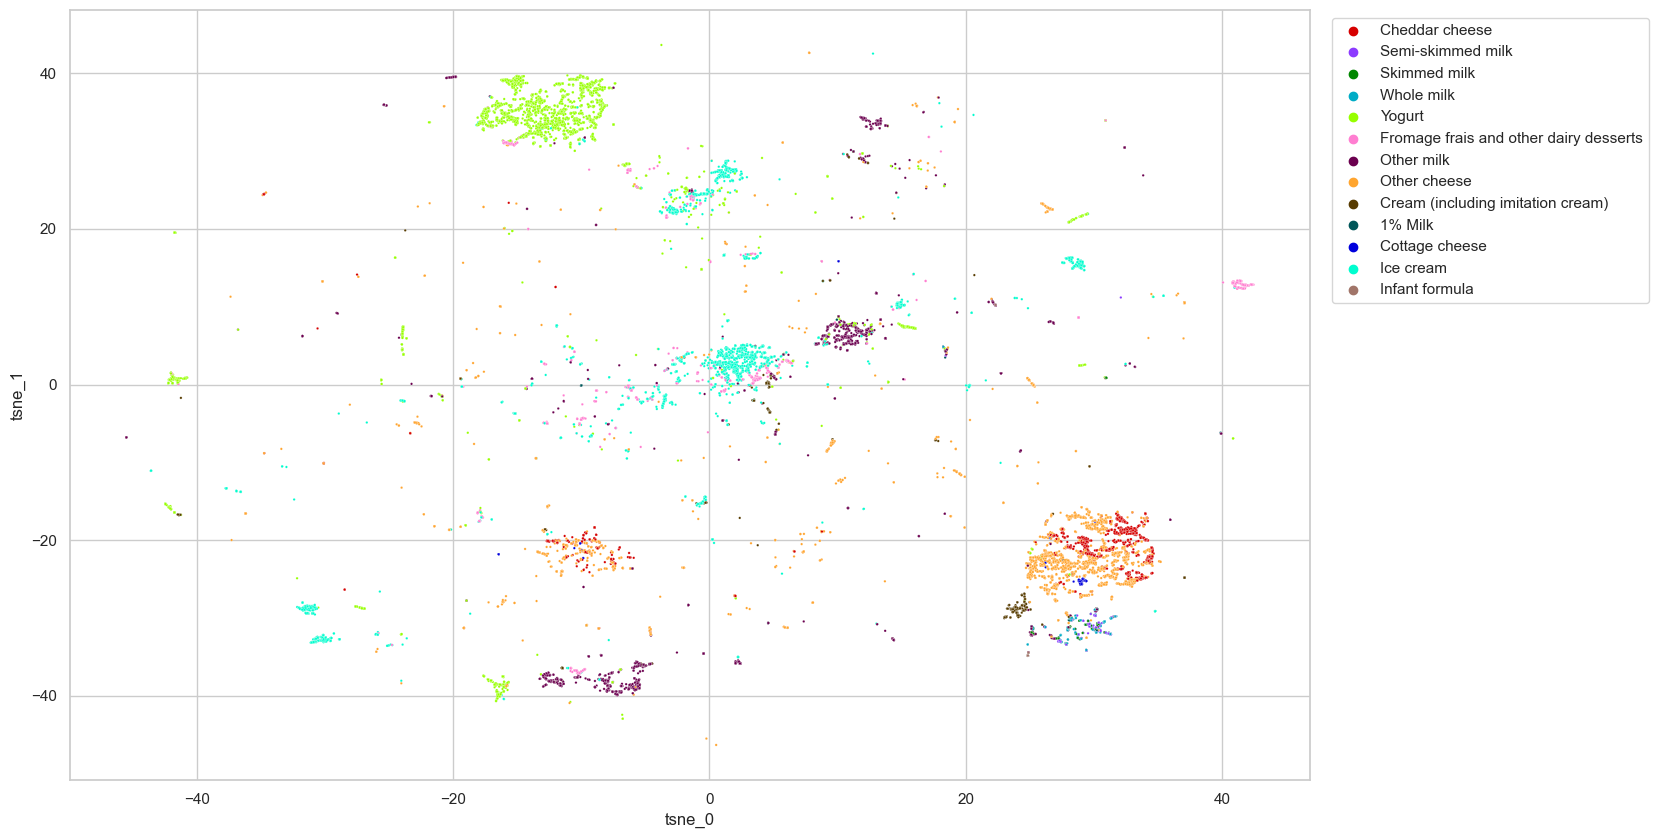

In [29]:
sns.set_style('whitegrid')
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=pred['tsne_0'], y=pred['tsne_1'],
    hue=pred['subfoodgroup_pred'],
    palette=sns.color_palette(cc.glasbey, n_colors=pred['subfoodgroup_pred'].nunique()), s=3
)
plt.legend(bbox_to_anchor=(1.28, 1), loc='upper right')

In [30]:
# save level 2 cereal categories
pred.to_csv('../../SFS/NDNS UK/predictions/predictions_milk_lev2_manuallabels_nonHI_RF_15Oct2024.csv', 
                      index=False)